#### 09. 회귀 실습 - 자전거 대여 수요 예측


- 데이터 클렌징 및 가공과 데이터 시각화

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

bike_df=pd.read_csv('../DATA/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year']=bike_df.datetime.apply(lambda x:x.year)
bike_df['month']=bike_df.datetime.apply(lambda x:x.month)
bike_df['day']=bike_df.datetime.apply(lambda x:x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x:x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


- 불필요 컬럼 삭제

In [3]:
drop_columns=['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

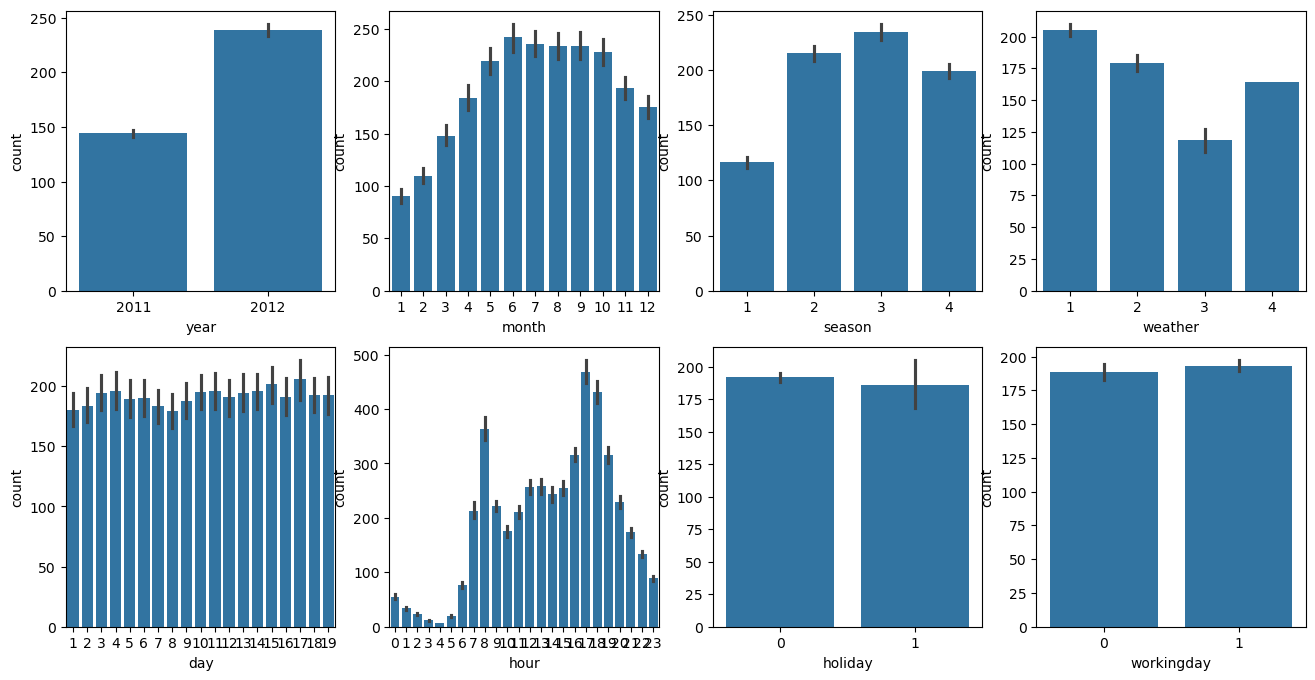

In [4]:
fig, axs=plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features=['year','month','season','weather','day','hour','holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row=int(i/4)
    col=i%4
    # seaborn의 barplot을 이용해 컬럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

- 회귀 모델을 데이터 세트에 적용해 예측 성능 측정해 보기

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y - log_pred) **2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val=rmsle(y, pred)
    rmse_val=rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val=mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

- 사이킷런의 LinearRegression 객체를 이용해 회귀 예측

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target=bike_df['count']
X_features=bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3,
                                                  random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [7]:
def get_top_error_data(y_test, pred, n_tops=5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성.
    result_df=pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count'] - result_df['predicted_count'])

# 예측값과 실제 값이 가장 큰 데이터 순을로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


- 큰 예측 오류가 발생할 경우 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인
- 자전거 대여 모델의 Target 값인 count 칼럼 확인

<Axes: >

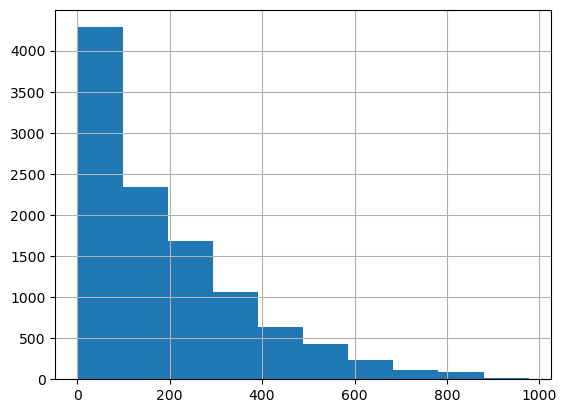

In [8]:
y_target.hist()

<Axes: >

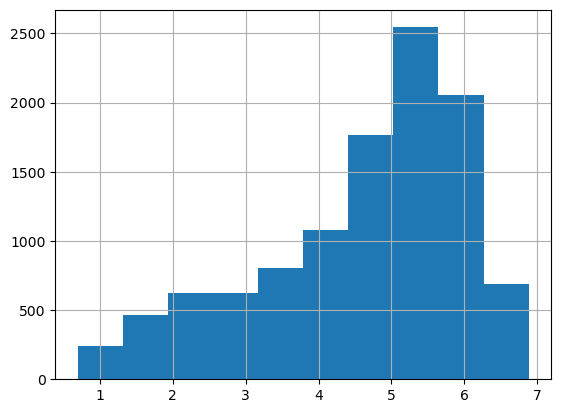

In [9]:
# 로그를 적용해 정규 분포 형태로 변환
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [10]:
# 타겟 컬럼인 count 값을 log1p로 로그 변환
y_target_log=np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 epm1을 이용해 원래 스케일로 변환
y_test_exp=np.expm1(y_test)

# 예측값 역시 로그 변환된 타겟 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp=np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


- RMSLE 오류는 줄었지만 RMSE는 오히려 더 늘었다
- 각 피쳐의 회귀 계수값을 시각화

<Axes: ylabel='None'>

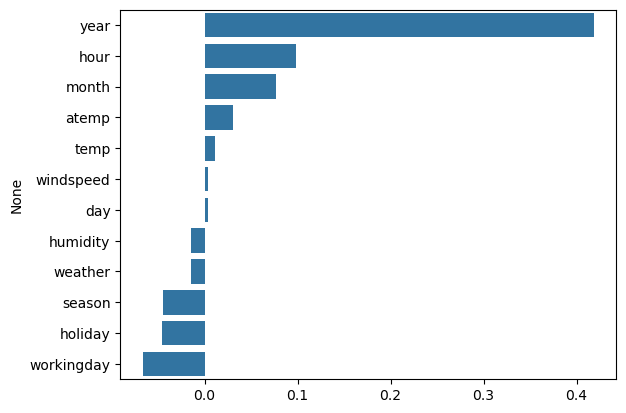

In [11]:
coef=pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [12]:
# 'year', 'month', 'day', 'hour' 등의 피쳐들을 One Hot Encoding
X_features_ohe=pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

- scikit-learn의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습하고 예측 성능 확인

In [13]:
# 원-핫 인코딩이 적용된 피쳐 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test=train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델 별로 평가 수행
lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


- One Hot Encoding 적용 후 선형 회귀 예측 성능이 많이 향상됨을 확인
- One Hot Encoding 적용한 데이터 세트에서 회귀 계수가 높은 피처 상위 20개를 시각화

<Axes: ylabel='None'>

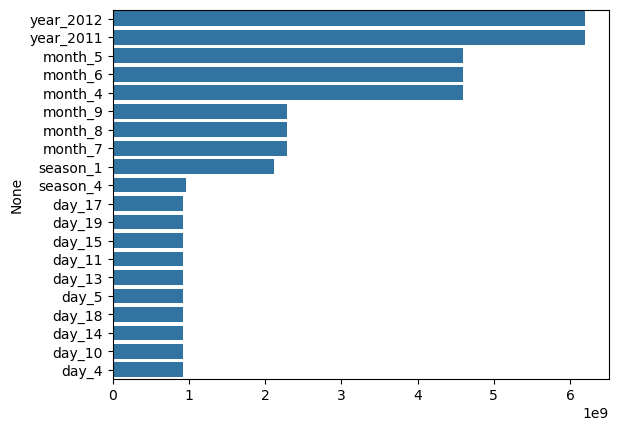

In [14]:
coef=pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort=coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- 선형 회귀의 경우 중요 카테고리성 피처들을 원-핫 인코딩으로 변환하는 것은 성능에 중요한 영향을 미칠 수 있다.